The goal is to load all the questions
then turn them to embeddings
and cluster them in 4 clusters

In [1]:
import csv 

question_file = 'data/questions.csv'
reader = csv.reader(open(question_file, 'r'))
print(next(reader)) # skip header
questions, categories = zip(*[(row[2], row[8])  for row in reader])

# print first 10 questions
for cat, q in zip(categories[:10], questions[:10]):
    print(cat, q)

['ID', 'Question', 'Traduction', 'Score', 'Alexandre *', 'Diego *', 'Notes', 'Category', 'Mood', 'Mood feedback Alexandre', 'Difficulty', 'Tags', "Alexandre's View", 'Notes']
Uplifting What does your ideal evening look like?
Uplifting What does a perfect day look like for you?
Uplifting What brings you most a sense of wonder in the natural world?
Uplifting What motivates you to do what you do?
Vulnerable What makes you angry?
Uplifting What product still gives you happiness, long after the feeling of novelty has passed?
Uplifting What is one of your dreams?
Debate What is something surprinsing in your field of expertise?
Uplifting What book, podcast or movie do you recommend without restraint?
Uplifting What book, podcast or movie had a major impact on you?


In [ ]:
# turn them into embeddings
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

print("Model size:", sum(p.numel() for p in model.parameters()))

In [75]:
embeddings = model.encode(questions)
# normalize embeddings
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
print("Embeddings shape:", embeddings.shape)

Embeddings shape: (137, 384)


In [76]:
# k-means clustering to find similar questions
from sklearn.cluster import KMeans
NUM_CLUSTERS = 4

kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0, n_init=100).fit(embeddings)

In [5]:
# Show the clusters
for i in range(NUM_CLUSTERS):
    print("\nCluster", i)
    for j in range(len(questions)):
        if kmeans.labels_[j] == i:
            # print(categories[j], questions[j])
            print(questions[j])


Cluster 0
Why have we not encountered extraterrestrial life yet?
If aliens landed on Earth, what would they be impressed by?
If aliens landed on Earth, what would they find most bizarre?
Would you rather have a perfect memory, or only need to sleep two hours a day?
If in the future you had to replace a part of your body with a prosthesis, what part would it be?
If you could have a drink with anyone in the world, who would it be?
What major change do you anticipate for next year?
Do you wish to have children?
How much would you sell your soul for?
If you find that mathematics are incoherent, how would you react?
If you weren't to be a human, what would you be?
In which country would you like to live?
What do you want to improve on in the near future?
If you could spend a night under the stars with anyone in the world, who would it be?
How do you solve Pascal's Mugging?
How long will there be humans on Earth?
Are you more optimistic or pessimistic about the future?
How are you going to 

In [77]:
# Find the 3 question closest to the center of each cluster

for i in range(NUM_CLUSTERS):
    print("\nCluster", i)
    center = kmeans.cluster_centers_[i]
    sims = np.linalg.norm(embeddings - center, axis=1)
    closest = sims.argsort()[:10]
    for j in closest:
        print(kmeans.labels_[j], categories[j], questions[j])


Cluster 0
0 Regard sur le monde If you could know one thing about the future, what would it be?
0 Perso - Easy If you weren't to be a human, what would you be?
0 Regard sur le monde If you could change any part of the world with a magic wand, what would you do?
0 Perso - Easy If you had a billion dollars, what would you do?
1 Perso - Easy If you could change one thing instantly, what would make you happy?
0 About the world What would humans do if they no longer needed to work?
0 Regard sur le monde What is the greatest threat to humanity in your field of expertise?
0 Regard sur le monde If in the future you had to replace a part of your body with a prosthesis, what part would it be?
0 Perso - Hard If you stopped your studies today, what would you do?
0 Perso - Easy How would your life change if you had a universal basic income of 1000$ per month?

Cluster 1
1 Perso - Easy What event from your childhood had the most impact on what you do today?
1 Perso - Hard What is one of your deepes

In [7]:
# Plot in 3D the distance of each question to the center of the first 3 clusters
import plotly.express as px
import numpy as np

distances = np.zeros((len(questions), NUM_CLUSTERS))
for i in range(NUM_CLUSTERS):
    center = kmeans.cluster_centers_[i]
    distances[:, i] = np.linalg.norm(embeddings - center, axis=1)

fig = px.scatter_3d(distances, x=0, y=1, z=2, color=kmeans.labels_)
fig.show()

In [70]:
# Do a PCA of the embedding and plot the first 2 dimensions
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(embeddings)
embeddings_2d = pca.transform(embeddings)
# convert to dataframe
import pandas as pd
embeddings_2d = pd.DataFrame(embeddings_2d)
embeddings_2d['question'] = questions

fig = px.scatter(embeddings_2d, x=0, y=1, color=kmeans.labels_, hover_data='question')
# Plot the position of the cluster centers
centers = pca.transform(kmeans.cluster_centers_)
centers = pd.DataFrame(centers)
centers['cluster'] = range(NUM_CLUSTERS)
fig.add_scatter(x=centers[0], y=centers[1], mode='markers', marker=dict(size=10, color='black'), hoverinfo='text', text=centers['cluster'])

fig.show()

In [ ]:
# Visualize the embeddings with UMAP
import umap
import umap.plot
umap.plot.output_notebook()

In [83]:

mapper = umap.UMAP(n_neighbors=10,
                            n_components=2,
                            min_dist=0.0,
                            # metric='cosine',
                            ).fit(embeddings)
# add questions to dataframe
umap_embeddings = pd.DataFrame(mapper.embedding_)
umap_embeddings['question'] = questions
umap_embeddings['category'] = categories
umap_embeddings['cluster'] = kmeans.labels_

/home/diego/.local/lib/python3.10/site-packages/umap/plot.py:885: UserWarning:

Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!



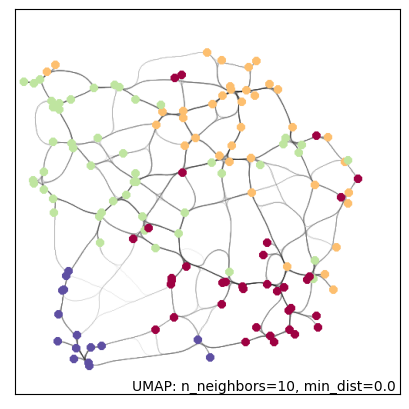

In [84]:
hover_data = pd.DataFrame({'question': questions, 'cluster': kmeans.labels_, 'category': categories})
fig = umap.plot.connectivity(mapper, show_points=True, edge_bundling='hammer',
# fig = umap.plot.interactive(mapper, hover_data=hover_data, 
    # labels=umap_embeddings['category'], 
    labels=umap_embeddings['cluster'], 
    width=500, height=500)
# umap.plot.points(mapper, labels=kmeans.labels_, theme='fire')
umap.plot.show(fig)

fig2 = umap.plot.interactive(mapper, hover_data=hover_data, 
    # labels=umap_embeddings['category'], 
    labels=umap_embeddings['cluster'], 
    width=500, height=500)

umap.plot.show(fig2)